In [9]:
train_file = r"/home/leonnico/Documents/UP/ANLP/sarcasm_detector_UP/train.En (1).csv"
test_file = r"/home/leonnico/Documents/UP/ANLP/sarcasm_detector_UP/task_A_En_test.csv"
EPOCHS = 1000
THRESHOLD = 0.35

In [10]:
# Map contractions
contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [11]:
import pandas as pd
import numpy as np
import re
import demoji
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load data
data = pd.read_csv(train_file) # Replace 'data.csv' with your CSV file name

# Preprocess text data
def preprocess_text(text):
    # Map contractions
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Replace emojis with their meanings
    text = demoji.replace(text)
    return text

data['tweet'] = data['tweet'].astype(str)  # Convert to string type
data['tweet'] = data['tweet'].apply(preprocess_text)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])
vocab_size = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(data['tweet'])
X = pad_sequences(X, padding='post')

# Create train-test split
y = np.array(data['sarcastic'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(y)

# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=X.shape[1]),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('sarcasm_detection_model.keras') # Save the trained model

# Inference method
def predict_sarcasm(sentences):
    # Preprocess input sentences
    preprocessed_sentences = [preprocess_text(sentence) for sentence in sentences]
    # Tokenize and pad sequences
    sequences = tokenizer.texts_to_sequences(preprocessed_sentences)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=X.shape[1])
    # Predict
    predictions = model.predict(padded_sequences)
    # Apply threshold
    binary_predictions = (predictions > THRESHOLD).astype(int)
    return binary_predictions

ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 61}

In [8]:
sentences = ["I'm soooo excited! #sarcasm", "This is the best day ever!"]
predictions = predict_sarcasm(sentences)
print(predictions)

NameError: name 'predict_sarcasm' is not defined

In [ ]:
sentences = pd.read_csv(test_file)
sentences['Predicted_sarcastic'] = pd.DataFrame(predict_sarcasm(sentences.iloc[:,0]))
# predictions = 
# print(predictions)
sentences

In [ ]:
sentences.sarcastic.value_counts(dropna = False, normalize= True).reset_index()

In [6]:
sentences.Predicted_sarcastic.value_counts(dropna = False, normalize= True).reset_index()

NameError: name 'sentences' is not defined

In [51]:
sentences.Predicted_sarcastic.value_counts(dropna = False).reset_index()

,Predicted_sarcastic,count
0,0,1393
1,1,7


In [52]:
X.shape[1]

61

In [53]:
correct = sentences[sentences.sarcastic==sentences.Predicted_sarcastic]
accuracy = correct.shape[0] / sentences.shape[0]
print(round(accuracy, 2),"%")

0.86 %


In [54]:
correct

,text,sarcastic,Predicted_sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0,0
1,Pinball!,0,0
3,villainous pro tip : change the device name on...,0,0
4,I would date any of these men 🥺,0,0
5,"If there's one fictional place I could go, Chr...",0,0
...,...,...,...
1392,Based on the government’s handling of the covi...,0,0
1394,I would imply that this friend has a tendency ...,0,0
1395,I’ve just seen this and felt it deserved a Ret...,0,0
1396,Omg how an earth is that a pen !!! 🤡,0,0


In [55]:
wrong = sentences[sentences.sarcastic!=sentences.Predicted_sarcastic]
wrong

,text,sarcastic,Predicted_sarcastic
2,So the Scottish Government want people to get ...,1,0
9,Sometimes I lay in bed and think about how tod...,1,0
21,"Max Verstappen is such a clean driver, he neve...",1,0
35,Boris looked so statesman-like in that public ...,1,0
47,Wow the Prime Minister is so good at the telli...,1,0
...,...,...,...
1371,I see ITV have new drama starting next week th...,1,0
1384,I think Boris Johnson deserves his parties aft...,1,0
1393,And the police clearly have nothing better to do,1,0
1398,"I love it when women are referred to as ""girl ...",1,0


In [56]:
sentences[['sarcastic', 'Predicted_sarcastic']].value_counts().reset_index()

,sarcastic,Predicted_sarcastic,count
0,0,0,1196
1,1,0,197
2,0,1,4
3,1,1,3


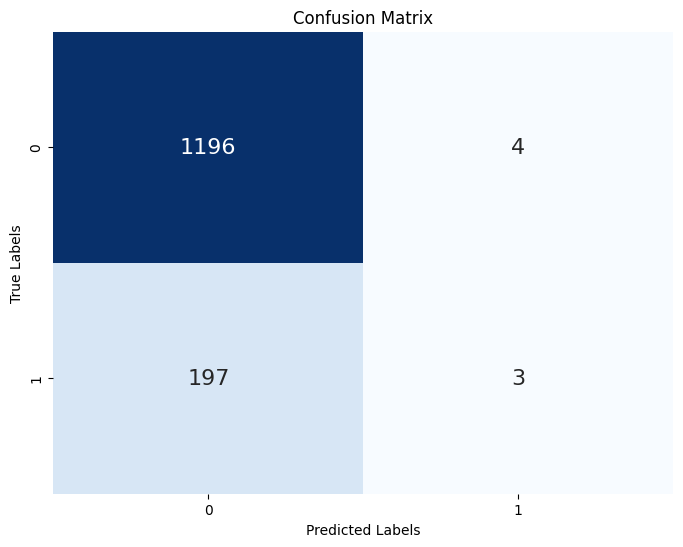

In [57]:
cm = confusion_matrix(sentences['sarcastic'], sentences['Predicted_sarcastic'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()